<a href="https://colab.research.google.com/github/cody-little/Unsupervised-Learning-for-Feature-Engineering/blob/master/Unsupervised_Vs_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning: A Comparitive Analysis of How to Evaluate Clusters and Then Use them as Features in a Supervised Task

### Summary
This is a machine learning project that seeks to classify wine quality through a multiclass prediction method. The overall goal is to compare outcomes using a feature space that includes an unsupervised feature in the form of a k-means clustering algorithim label to an original feature space utilizing a grid search and 5 fold cross validated single decision tree model. Below is a breakdown of how this is done

* Load data, and explore it
* Create an unsupervised feature label through optimizing the number of clusters with a k-means algorithim, evaluating the number of clusters through multiple modicums of metrics
* Develop an optimal single decision tree using a grid search cross validation technique for each feature space (one including a cluster feature, and one without)
* Report Results Across Multiple Metrics


### Load and Prepare Data and Libraries

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DYKawQxmzHYUpj0j6RMzjl4d6ZdSwXMy' -O wine.csv

--2020-07-30 20:57:28--  https://docs.google.com/uc?export=download&id=1DYKawQxmzHYUpj0j6RMzjl4d6ZdSwXMy
Resolving docs.google.com (docs.google.com)... 172.217.193.100, 172.217.193.113, 172.217.193.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.193.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/focd3t098sofdhsjdag1ti3hckjnau77/1596142575000/05129054582585331303/*/1DYKawQxmzHYUpj0j6RMzjl4d6ZdSwXMy?e=download [following]
--2020-07-30 20:57:28--  https://doc-0s-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/focd3t098sofdhsjdag1ti3hckjnau77/1596142575000/05129054582585331303/*/1DYKawQxmzHYUpj0j6RMzjl4d6ZdSwXMy?e=download
Resolving doc-0s-bs-docs.googleusercontent.com (doc-0s-bs-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connecting to doc-0s-bs-docs.googleusercontent.com (doc-0s-b

In [2]:
#Load all libraries#
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import re
import calendar
import json
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
wine = pd.read_csv('wine.csv')
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Exploratory Data Analysis 

This is a brief exploratory analysis where I look at the overall distribution of the variables in this data set to get a better understanding of what relates to wine quality.

Using a table we can understand all of the variables vary wildly associated to the ways in which they are measured. This will be important to rememeber later if we want to use a k-means algorithim because if the variables making up our dimensions are on different scales we wont get the best results.

In [4]:
#Basic description of data since it is all numeric#
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [5]:
#Check how many quality scores there are#
print(wine['quality'].value_counts())

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


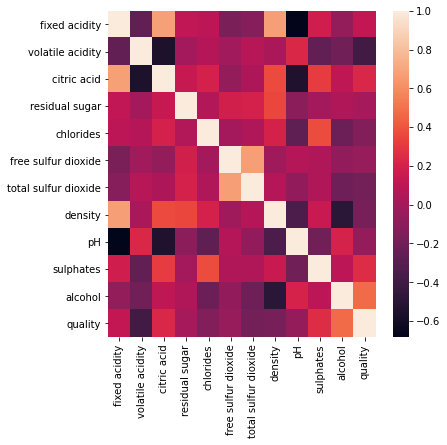

In [6]:
#Generate a Correlation Plot#
plt.figure(figsize= (6, 6))
sns.heatmap(wine.corr())

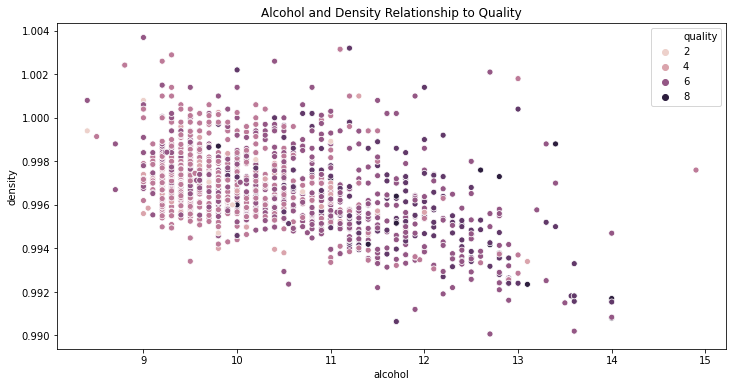

In [7]:
plt.figure(figsize=(12,6))
ax =sns.scatterplot(x="alcohol", y="density",
              hue="quality",
              data=wine).set_title('Alcohol and Density Relationship to Quality')

### Prepare Data for Method Comparison

This cell normalizes the data within our wine data set. Since they are all numeric we need to account for varying distributions within the data. Using sklearns min/max scaler we can normalize all of the data so it only ranges from 0-1.

In [8]:
## Here we make unsupervised clusters of the data set
scaler = MinMaxScaler()

wine_norm = wine.drop(['quality'], axis = 1)
columnnames = wine_norm.columns
wine_norm = pd.DataFrame(scaler.fit_transform(wine_norm))
wine_norm.columns = columnnames

### First Method of Comparing Clusters: Human Judgement

This next cell may seem long but it enables me to understand what the model is doing and how the k-means algorithim is deciding the clusters. Essentially I create a function that will take the mean of each feature within every cluster and print it. I can also change the number of clusters to evaluate and see how the percentage of data points within each cluster changes. Along with this I can create 2 dimensional scatter plots and assign the color to the cluster id within these unsupervised labels, that allows me to visually see how the clusters are seperated.

Using this method of human judgement I can watch as the means for each feature change depending to their relative importance to the number of clusters. While this method can provide strong insight it also can be very misleading if you don't take a decent amount of time to go through and understand the ways in which each mean changes reflecting a variation in the number of clusters. When all said and done this provides a very subjective view for the researcher to understand the ideal number of clusters. 

In [9]:
from sklearn.cluster import KMeans

def describe_cluster(cluster_instances): 
  fixed_acidity = cluster_instances["fixed acidity"].mean()
  volatile_acidity = cluster_instances['volatile acidity'].mean()
  citric_acid = cluster_instances['citric acid'].mean()
  residual_sugar = cluster_instances['residual sugar'].mean()
  chlorides = cluster_instances['chlorides'].mean()
  free_sulfur_dioxide = cluster_instances['free sulfur dioxide'].mean()
  total_sulfur = cluster_instances['total sulfur dioxide'].mean()
  density = cluster_instances['density'].mean()
  pH = cluster_instances['pH'].mean()
  sulphates = cluster_instances['sulphates'].mean()
  alcohol = cluster_instances['alcohol'].mean()
  print(f'Fixed acidity mean {fixed_acidity:.2f}')
  print(f'Volatile Acidity Mean {volatile_acidity:.2f}')
  print(f'Citric Acid mean {citric_acid:.2f}')
  print(f'Residual Sugar mean {residual_sugar:.2f}')
  print(f'Chlorides mean {chlorides:.2f}')
  print(f'Free Sulfur mean {free_sulfur_dioxide:.2f}')
  print(f'Total Sulfur mean {total_sulfur:.2f}')
  print(f'Density mean {density:.2f}')
  print(f'pH value mean {pH:.2f}')
  print(f'Sulphates mean {sulphates:.2f}')
  print(f'Alcohol mean {alcohol:.2f}')




for k in range(2,5):
  print(f"Cluster Statistics for k = {k}")

  learner = KMeans(n_clusters=k)
  clusters = learner.fit(wine_norm)



  wine_norm["cluster"] = clusters.labels_
  for cluster_id in wine_norm["cluster"].unique():
        print(f"Cluster {cluster_id}")
        cluster_instances = wine_norm.loc[wine_norm.cluster == cluster_id]
        print(f"  {100*len(cluster_instances)/len(wine_norm):.1f}% of data.")
        describe_cluster(cluster_instances)

  print(f"-_-_-_-_-_-_-_-_-_-_-_-_-_-_")

Cluster Statistics for k = 2
Cluster 0
  58.7% of data.
Fixed acidity mean 0.24
Volatile Acidity Mean 0.33
Citric Acid mean 0.14
Residual Sugar mean 0.10
Chlorides mean 0.12
Free Sulfur mean 0.22
Total Sulfur mean 0.15
Density mean 0.45
pH value mean 0.50
Sulphates mean 0.16
Alcohol mean 0.29
Cluster 1
  41.3% of data.
Fixed acidity mean 0.45
Volatile Acidity Mean 0.20
Citric Acid mean 0.46
Residual Sugar mean 0.13
Chlorides mean 0.14
Free Sulfur mean 0.19
Total Sulfur mean 0.13
Density mean 0.55
pH value mean 0.38
Sulphates mean 0.24
Alcohol mean 0.34
-_-_-_-_-_-_-_-_-_-_-_-_-_-_
Cluster Statistics for k = 3
Cluster 2
  40.7% of data.
Fixed acidity mean 0.27
Volatile Acidity Mean 0.33
Citric Acid mean 0.15
Residual Sugar mean 0.10
Chlorides mean 0.12
Free Sulfur mean 0.23
Total Sulfur mean 0.17
Density mean 0.50
pH value mean 0.47
Sulphates mean 0.16
Alcohol mean 0.21
Cluster 1
  41.3% of data.
Fixed acidity mean 0.45
Volatile Acidity Mean 0.20
Citric Acid mean 0.46
Residual Sugar mea

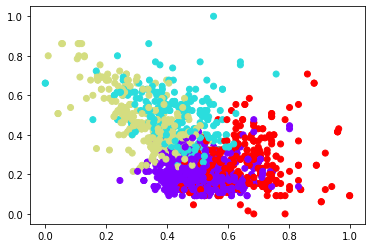

In [10]:
#If we want we can look at how the clusters change
plt.scatter(wine_norm["density"], wine_norm['alcohol'], c = wine_norm["cluster"], cmap = "rainbow")
plt.show()

### Second Method of Comparing Clusters: Silouhette Score

In [11]:
from sklearn.metrics import silhouette_score as silly

sils = []


for i in range(2,11):
  learner = KMeans(n_clusters=i, random_state=500)
  clusters = learner.fit(wine_norm)
  wine_norm["cluster"] = clusters.labels_
  silouhette = silly(wine_norm, wine_norm["cluster"])
  sils.append(silouhette)

  print(f"K = {i}, silouette = {silouhette: .3f} ")

K = 2, silouette =  0.517 
K = 3, silouette =  0.567 
K = 4, silouette =  0.610 
K = 5, silouette =  0.638 
K = 6, silouette =  0.637 
K = 7, silouette =  0.643 
K = 8, silouette =  0.663 
K = 9, silouette =  0.679 
K = 10, silouette =  0.672 


**Cluster Decision**
Below we make the final clusters we want to use for the next task. Given the previous two methods of evaluating the clusters I have chosen to go with 9 cluster labels to use as features within the supervised learning task. I chose this because of what I saw within the human judgement analysis in the ways that the means for each vairbale changed within the clusters and the silhouette scores that the 9 cluster Kmeans achieved. I chose 9 rather than ten because a .03 difference within the score coeffecient is marginal and increasing the clusters beyond 9 does not bring a lot of inherent value.

In [12]:
final_learner = KMeans(n_clusters=9)
final_learner_clusters = final_learner.fit(wine_norm)
wine_norm["cluster"] = final_learner_clusters.labels_

## Using the Clusters as Features

The next few cells get into the gritty data manipulation and building in order to make the required splits for the models to be fit on a grid search. A couple imporntant things to remember for anyone looking through the code:

* There are two different training sets, they are almost identical, the only difference is the train set for clusters includes the cluster label given during the previous unsupervised learning portion of this project
*  Because of this extra cluster I use two different grid searches on the Decision Tree Algorithim (I'm almost positive sklearn uses CART if anyones interested in that level of detail), I cross validate aross 5 folds because 100/5 = 20 and 20% of the original sized data set is the size of the test set they will be evaluated on. I look across a few different hyperperamters; splitting criterion, depth of the tree, the number of features, and the mode of splitting. 
* I chose to change the metric from accuracy to cohen's kappa score. I am a big fan of that metric when validating models because it takes into account the base probability of selection. This helps create hyperperamter optimization that generalizes better to future data for predictions.

* This is still a **6 way** classification task with a heavily unbalanced data set. Achieving reasonably succesful metrics on such a task is difficult due to problem definition, but the point of this project isn't to show how successful a decision tree is at classifying wine quality. It is to understand how an unsupervised learning label as a feature effects performance.

In [13]:
wine['cluster'] = wine_norm['cluster']
wine['cluster'].value_counts()

0    236
2    214
4    208
6    205
1    194
5    180
7    162
3    117
8     83
Name: cluster, dtype: int64

In [14]:
train_setC, test_set = train_test_split(wine, train_size = .80, test_size = .20,random_state = 500)
train_set = train_setC.drop(['cluster'],axis=1)
train_setC

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,cluster
982,7.3,0.520,0.32,2.1,0.070,51.0,70.0,0.99418,3.34,0.82,12.9,6,8
1276,8.5,0.400,0.40,6.3,0.050,3.0,10.0,0.99566,3.28,0.56,12.0,4,1
685,8.1,0.780,0.23,2.6,0.059,5.0,15.0,0.99700,3.37,0.56,11.3,5,6
1083,8.7,0.420,0.45,2.4,0.072,32.0,59.0,0.99617,3.33,0.77,12.0,6,3
630,8.7,0.540,0.26,2.5,0.097,7.0,31.0,0.99760,3.27,0.60,9.3,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,7.5,0.400,0.12,3.0,0.092,29.0,53.0,0.99670,3.37,0.70,10.3,6,0
957,9.5,0.370,0.52,2.0,0.088,12.0,51.0,0.99613,3.29,0.58,11.1,6,1
273,8.4,0.715,0.20,2.4,0.076,10.0,38.0,0.99735,3.31,0.64,9.4,5,4
951,8.3,0.280,0.48,2.1,0.093,6.0,12.0,0.99408,3.26,0.62,12.4,7,1


In [15]:
#make a grid search for with and without the clusters#
#Make a simple grid search for a decision tree with clusters#
Vcluster_X = train_setC.drop(['quality'],axis=1)
Vcluster_y = train_setC['quality']

kap_scorer = make_scorer(cohen_kappa_score)
DT_Clusters_cv = GridSearchCV(DecisionTreeClassifier(random_state=500), param_grid={'criterion': ['gini','entropy'], 'max_depth': [100,500,1000,1500,2000,2500,3000],
                                                                    'splitter': ['best','random'], 'max_features':[None,'auto','log2']}, cv = 5, scoring = kap_scorer)
DT_Clusters_cv.fit(Vcluster_X,Vcluster_y)
print('Cluster Decision Tree')
print(DT_Clusters_cv.best_params_)
dt_clusterbest = DT_Clusters_cv.best_params_
print(f'best score is {DT_Clusters_cv.best_score_:.3f}')
print('_______________________________________________')
print()
#Make a simple grid search for decision tree without clusters#
V_X = train_set.drop(['quality'],axis=1)
V_y = train_set['quality']

DT_cv = GridSearchCV(DecisionTreeClassifier(random_state=500), param_grid={'criterion': ['gini','entropy'], 'max_depth': [100,500,1000,1500,2000,2500,3000], 
                                                           'splitter': ['best','random'], 'max_features':[None, 'auto', 'log2']}, cv = 5, scoring = kap_scorer)
DT_cv.fit(V_X,V_y)
print('Normal Decision Tree')
DTbest = DT_cv.best_params_
print(DT_cv.best_params_)
print(f'best score is {DT_cv.best_score_:.3f}')


Cluster Decision Tree
{'criterion': 'gini', 'max_depth': 100, 'max_features': None, 'splitter': 'best'}
best score is 0.390
_______________________________________________

Normal Decision Tree
{'criterion': 'gini', 'max_depth': 100, 'max_features': None, 'splitter': 'best'}
best score is 0.378


## Fitting the Final Models and Evaluating Results

Here I just fit the final models and generate some evaluation metrics using the optimized hyperperamters from before. Nothing special just standard scikit learn implementations

In [16]:
### Make Final Models and Test Them#
#split the test set#
testX = test_set.drop(['quality'],axis=1)
testX_nocluster=test_set.drop(['quality','cluster'],axis=1)
testy = test_set['quality']


#Fit both final models#
FinalCluster_DT = DecisionTreeClassifier(criterion='gini',max_depth=100,max_features=None,splitter='best',random_state=500).fit(Vcluster_X,Vcluster_y)
Final_DT = DecisionTreeClassifier(criterion='gini',max_depth=100, max_features=None, splitter = 'best',random_state=500).fit(V_X,V_y)

Cluster_predict = FinalCluster_DT.predict(testX)
DT_predict = Final_DT.predict(testX_nocluster)

#Get accuracy scores#
cluster_acc = accuracy_score(testy,Cluster_predict)
DT_acc = accuracy_score(testy,DT_predict)

cluster_kap = cohen_kappa_score(testy,Cluster_predict,weights='quadratic')
DT_kap = cohen_kappa_score(testy, DT_predict)
cluster_conf = confusion_matrix(testy,Cluster_predict)
DT_conf = confusion_matrix(testy,Cluster_predict)

**Surprising Results:**

The results for this project really surprised me. There were a lot of things that I would have considered a disadvantage given this task;

Task definition: Predict wine quality on a six point scale

Some disadvantages:
* Six way classification, when I first learned machine learning methods I was taught a good rule of thumb was to simplify a task, bring down the dimensionality of data (through PCA or some other method) and make the classification binary if possible. Because this is a six way classification the task is monumentally harder.

* Data set size, the data set size for the training set in this analysis is fairly small with only 1,279 instances and six possible labels I was uncertain if the classifier could learn anything at all.

* Heavy disproportionality among the target labels, the target labels in the data sat are not only six in number but are way too far from equal (there are some mathematical methods to address this but I didn't use them). 

* The biggest disadvantage is a combination of the previous few points. A majority of the instances in the test set were either a 'five' or a 'six' rating. I doubt any human taste tester could come close to discerning the subtle difference between such labels, let alone classify those along with the possibility for others.

* I was evaluating it using a single decision tree. Sometimes it is easy to forget how effective a single decision tree can be. Whenever I perform projects or academic research I often forgo the lolely single tree in favor of a random forest of some kind. This project brought my head out of the clouds and I will now include it in my model options because of its sheer effectiveness at such a difficult task.

In [17]:
print(test_set['quality'].value_counts()/len(test_set))

5    0.434375
6    0.371875
7    0.137500
4    0.046875
8    0.009375
Name: quality, dtype: float64


**Results:**

The results below show how incredibly well this CART algorithim performed at the task. Using a wide variety of chemical features from the wines both algorithhims performed well above baseline and far above random guessing. I was really surprised at this and it really is a true testament to how strong machine learning can perform at some simple tasks such as this. The most impressive thing in my opinion is both classifiers ability to discern a 'five' from a 'six'. While it also had the most instances to learn from that was the most difficulty label instances and both feature methods proved successful.

**The Winner:**

Looking at the results below it is hard to say who a clear winner is. The decision tree with a cluster label inlcuded in its features performed slightly worse in accuracy but much better in a quadratically rated Cohen's Kappa Score. Meanwhile the normal decision tree really held its own. 

Results
______________________________________________
Test Set Statistics
Baseline Accuracy: 43.4%
Random Guessing: 20%
_____________________________________________
Cluster Feature Inclusion Results
Accuracy is 0.616
Kappa is 0.513


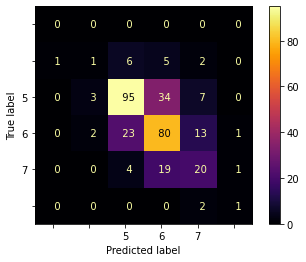


_____________________________________________
Normal Decision Tree Results
Accuracy is 0.634
Kappa is 0.432


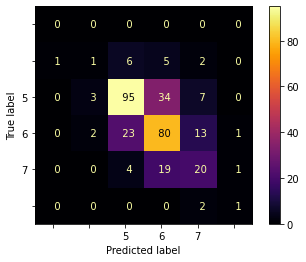

In [18]:
print('Results')
print('______________________________________________')
print('Test Set Statistics')
print('Baseline Accuracy: 43.4%')
print('Random Guessing: 20%')
print('_____________________________________________')
print('Cluster Feature Inclusion Results')
print(f'Accuracy is {cluster_acc:.3f}')
print(f'Kappa is {cluster_kap:.3f}')
ConfusionMatrixDisplay(cluster_conf,display_labels=['','','5','6','7','']).plot(values_format = '4g',cmap='inferno')
plt.show()
print()
print('_____________________________________________')
print('Normal Decision Tree Results')
print(f'Accuracy is {DT_acc:.3f}')
print(f'Kappa is {DT_kap:.3f}')
ConfusionMatrixDisplay(DT_conf,display_labels=['','','5','6','7','']).plot(values_format = '4g',cmap='inferno')
plt.show()
